In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

In [92]:
df = pd.read_csv('Website_visitors.csv')

# Data Preprocessing

In [93]:
print(df.head())

     Age  Gender     Users New Users   Sessions Bounce Rate  Pages / Session  \
0    65+  female  4,62,771  2,25,727  22,02,544      67.26%             1.88   
1  55-64  female  4,45,571  2,15,470  19,34,187      67.85%             1.90   
2  45-54  female  4,41,885  2,22,988  18,80,482      68.19%             1.91   
3  25-34  female  3,75,829  2,10,428  15,47,021      68.26%             1.95   
4  45-54    male  3,73,548  1,91,484  16,23,042      68.22%             1.90   

  Avg. Session Duration Transactions          Revenue  \
0              00:02:27        1,575    NZ$828,088.90   
1              00:02:25        1,859  NZ$1,166,774.92   
2              00:02:23        2,013  NZ$1,272,479.67   
3              00:02:27        2,285  NZ$1,788,988.56   
4              00:02:29        1,638    NZ$935,898.38   

  Ecommerce Conversion Rate  
0                     0.07%  
1                     0.10%  
2                     0.11%  
3                     0.15%  
4                     0.10

In [94]:
df = df.dropna(subset=['Age'])

In [95]:
print(df)

      Age  Gender     Users New Users   Sessions Bounce Rate  Pages / Session  \
0     65+  female  4,62,771  2,25,727  22,02,544      67.26%             1.88   
1   55-64  female  4,45,571  2,15,470  19,34,187      67.85%             1.90   
2   45-54  female  4,41,885  2,22,988  18,80,482      68.19%             1.91   
3   25-34  female  3,75,829  2,10,428  15,47,021      68.26%             1.95   
4   45-54    male  3,73,548  1,91,484  16,23,042      68.22%             1.90   
5   55-64    male  3,64,955  1,75,018  16,26,306      67.60%             1.89   
6   25-34    male  3,57,661  2,07,157  15,27,964      69.67%             1.88   
7   35-44  female  3,53,895  1,84,368  14,30,119      68.12%             1.92   
8     65+    male  3,35,822  1,53,539  16,45,170      65.99%             1.92   
9   35-44    male  3,21,190  1,75,314  13,25,544      68.22%             1.92   
10  18-24  female  1,96,957  1,09,269   6,77,168      66.52%             2.08   
11  18-24    male  1,69,028 

In [96]:
print(df.dtypes)

Age                           object
Gender                        object
Users                         object
New Users                     object
Sessions                      object
Bounce Rate                   object
Pages / Session              float64
Avg. Session Duration         object
Transactions                  object
Revenue                       object
Ecommerce Conversion Rate     object
dtype: object


In [97]:
df['Age'] = df['Age'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [98]:
df['Revenue'] = df['Revenue'].str.replace('NZ\$', '').str.replace(',', '').astype(float)
df['Ecommerce Conversion Rate'] = df['Ecommerce Conversion Rate'].str.replace('%', '').astype(float) / 100
df['Bounce Rate'] = df['Bounce Rate'].str.replace('%', '').astype(float) / 100

C:\Users\Shivraj\AppData\Local\Temp\ipykernel_13428\2518385577.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Revenue'] = df['Revenue'].str.replace('NZ\$', '').str.replace(',', '').astype(float)


In [99]:
df['Avg. Session Duration'] = pd.to_timedelta(df['Avg. Session Duration'])

# Split the Avg. Session Duration column into hours, minutes, and seconds
df['Hours'] = df['Avg. Session Duration'].dt.seconds // 3600
df['Minutes'] = (df['Avg. Session Duration'].dt.seconds // 60) % 60
df['Seconds'] = df['Avg. Session Duration'].dt.seconds % 60

# Convert the Avg. Session Duration column to total seconds
df['Avg. Session Duration'] = df['Hours']*3600 + df['Minutes']*60 + df['Seconds']

# Drop the temporary columns
df = df.drop(columns=['Hours', 'Minutes', 'Seconds'])

In [100]:
for column in ['Users', 'New Users', 'Sessions', 'Transactions']:
    df[column] = df[column].str.replace(',', '').astype(int)


In [101]:
print(df.head())

     Age  Gender   Users  New Users  Sessions  Bounce Rate  Pages / Session  \
0    65+  female  462771     225727   2202544       0.6726             1.88   
1  55-64  female  445571     215470   1934187       0.6785             1.90   
2  45-54  female  441885     222988   1880482       0.6819             1.91   
3  25-34  female  375829     210428   1547021       0.6826             1.95   
4  45-54    male  373548     191484   1623042       0.6822             1.90   

   Avg. Session Duration  Transactions     Revenue  Ecommerce Conversion Rate  
0                    147          1575   828088.90                     0.0007  
1                    145          1859  1166774.92                     0.0010  
2                    143          2013  1272479.67                     0.0011  
3                    147          2285  1788988.56                     0.0015  
4                    149          1638   935898.38                     0.0010  


# Explanatory Data Analysis (EDA)

### User Demographic

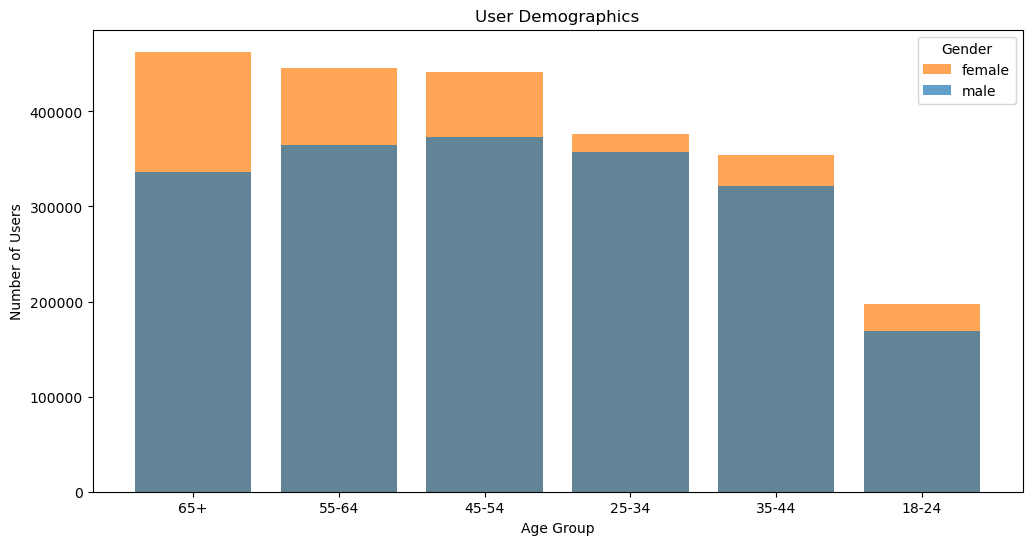

In [12]:
data_UD = {
    'Age': ['65+', '55-64', '45-54', '25-34', '45-54', '55-64', '25-34', '35-44', '65+', '35-44', '18-24', '18-24'],
    'Gender': ['female', 'female', 'female', 'female', 'male', 'male', 'male', 'female', 'male', 'male', 'female', 'male'],
    'Users': [462771, 445571, 441885, 375829, 373548, 364955, 357661, 353895, 335822, 321190, 196957, 169028]
}


fig, ax = plt.subplots(figsize=(12, 6))
gender_colors = {'female': 'tab:orange', 'male': 'tab:blue'}

for gender, group in df.groupby('Gender'):
    ax.bar(group['Age'], group['Users'], label=gender, color=gender_colors[gender], alpha=0.7)

ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Users')
ax.set_title('User Demographics')
ax.legend(title='Gender')

plt.show()

### User engagement

In [13]:
grouped_df = df.groupby(['Age', 'Gender']).mean().reset_index()
print(grouped_df)

      Age  Gender     Users  New Users   Sessions  Bounce Rate  \
0   18-24  female  196957.0   109269.0   677168.0       0.6652   
1   18-24    male  169028.0    97594.0   625880.0       0.6888   
2   25-34  female  375829.0   210428.0  1547021.0       0.6826   
3   25-34    male  357661.0   207157.0  1527964.0       0.6967   
4   35-44  female  353895.0   184368.0  1430119.0       0.6812   
5   35-44    male  321190.0   175314.0  1325544.0       0.6822   
6   45-54  female  441885.0   222988.0  1880482.0       0.6819   
7   45-54    male  373548.0   191484.0  1623042.0       0.6822   
8   55-64  female  445571.0   215470.0  1934187.0       0.6785   
9   55-64    male  364955.0   175018.0  1626306.0       0.6760   
10    65+  female  462771.0   225727.0  2202544.0       0.6726   
11    65+    male  335822.0   153539.0  1645170.0       0.6599   

    Pages / Session  Avg. Session Duration  Transactions     Revenue  \
0              2.08                  148.0        1199.0   882717.05 

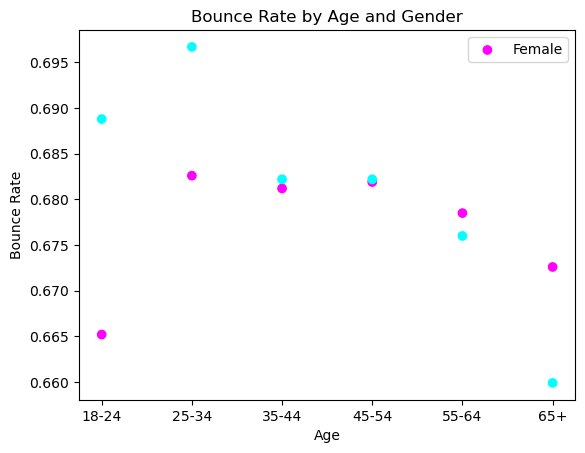

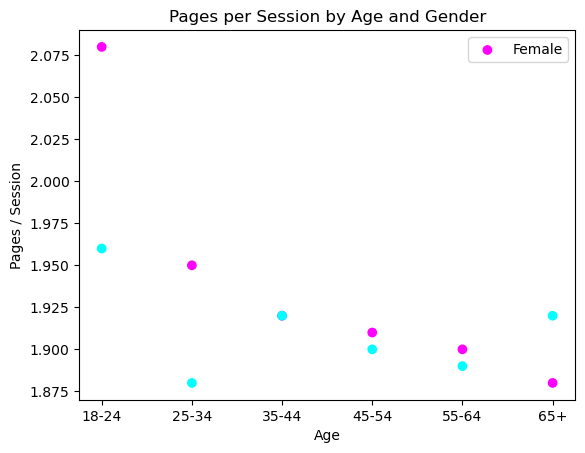

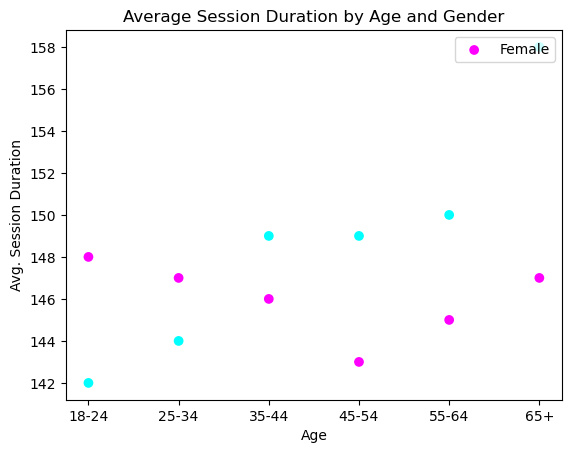

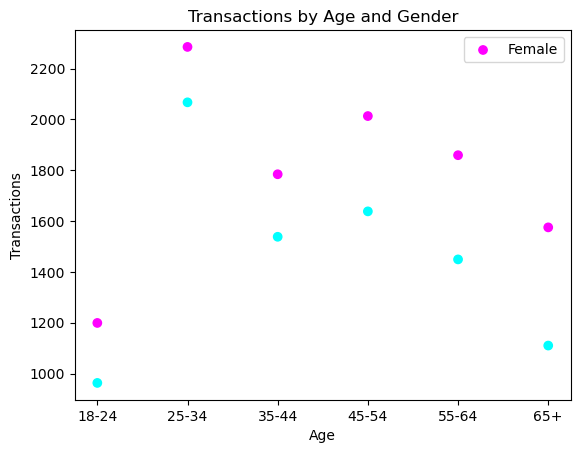

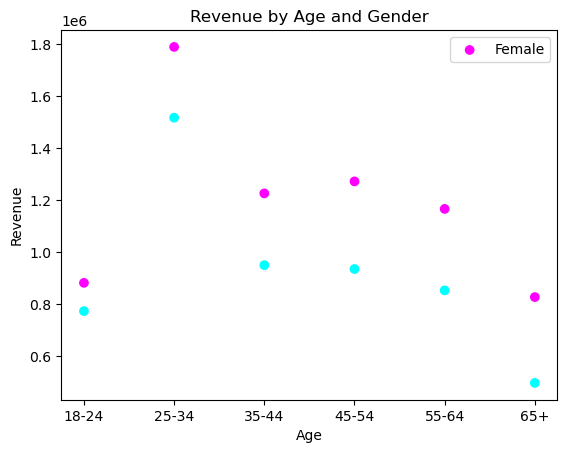

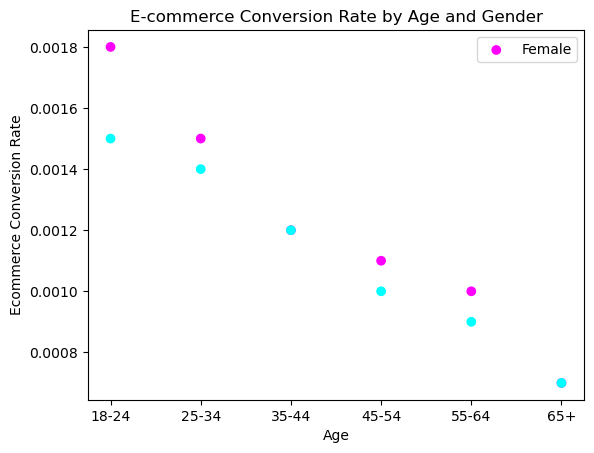

In [14]:
# Create a scatter plot for bounce rate
plt.scatter(grouped_df['Age'], grouped_df['Bounce Rate'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Bounce Rate')
plt.title('Bounce Rate by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()

# Create a scatter plot for pages per session
plt.scatter(grouped_df['Age'], grouped_df['Pages / Session'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Pages / Session')
plt.title('Pages per Session by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()

# Create a scatter plot for average session duration
plt.scatter(grouped_df['Age'], grouped_df['Avg. Session Duration'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Avg. Session Duration')
plt.title('Average Session Duration by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()

# Create a scatter plot for transactions
plt.scatter(grouped_df['Age'], grouped_df['Transactions'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Transactions')
plt.title('Transactions by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()

# Create a scatter plot for revenue
plt.scatter(grouped_df['Age'], grouped_df['Revenue'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Revenue')
plt.title('Revenue by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()

# Create a scatter plot for e-commerce conversion rate
plt.scatter(grouped_df['Age'], grouped_df['Ecommerce Conversion Rate'], c=grouped_df['Gender']=='female', cmap='cool')
plt.xlabel('Age')
plt.ylabel('Ecommerce Conversion Rate')
plt.title('E-commerce Conversion Rate by Age and Gender')
plt.legend(labels=['Female', 'Male'], loc='upper right')
plt.show()


### E-commerce Performance

In [15]:
# get the highest number of transactions by gender and age group
highest_transactions = df.loc[df['Transactions'] == df['Transactions'].max(), ['Gender', 'Age', 'Transactions']]
print("Highest number of transactions:")
print(highest_transactions)

# get the highest revenue by gender and age group
highest_revenue = df.loc[df['Revenue'] == df['Revenue'].max(), ['Gender', 'Age', 'Revenue']]
print("Highest revenue:")
print(highest_revenue)

# get the highest e-commerce conversion rate by gender and age group
highest_conversion_rate = df.loc[df['Ecommerce Conversion Rate'] == df['Ecommerce Conversion Rate'].max(), ['Gender', 'Age', 'Ecommerce Conversion Rate']]
print("Highest e-commerce conversion rate:")
print(highest_conversion_rate)

# print the entire dataset sorted by age group and gender
print("Full dataset sorted by age group and gender:")
print(df.sort_values(['Age', 'Gender']))

Highest number of transactions:
   Gender    Age  Transactions
3  female  25-34          2285
Highest revenue:
   Gender    Age     Revenue
3  female  25-34  1788988.56
Highest e-commerce conversion rate:
    Gender    Age  Ecommerce Conversion Rate
10  female  18-24                     0.0018
Full dataset sorted by age group and gender:
      Age  Gender   Users  New Users  Sessions  Bounce Rate  Pages / Session  \
10  18-24  female  196957     109269    677168       0.6652             2.08   
11  18-24    male  169028      97594    625880       0.6888             1.96   
3   25-34  female  375829     210428   1547021       0.6826             1.95   
6   25-34    male  357661     207157   1527964       0.6967             1.88   
7   35-44  female  353895     184368   1430119       0.6812             1.92   
9   35-44    male  321190     175314   1325544       0.6822             1.92   
2   45-54  female  441885     222988   1880482       0.6819             1.91   
4   45-54    male  3

### Correlation analysis between user engagement metrics and e-commerce conversion rates

In [16]:
correlation_matrix = df.corr()
print(correlation_matrix)

                              Users  New Users  Sessions  Bounce Rate  \
Users                      1.000000   0.957799  0.979346     0.028975   
New Users                  0.957799   1.000000  0.902323     0.246952   
Sessions                   0.979346   0.902323  1.000000    -0.072477   
Bounce Rate                0.028975   0.246952 -0.072477     1.000000   
Pages / Session           -0.732459  -0.707481 -0.768670    -0.365288   
Avg. Session Duration      0.010851  -0.145646  0.140800    -0.740628   
Transactions               0.666582   0.830441  0.533512     0.491171   
Revenue                    0.315651   0.540835  0.161874     0.611463   
Ecommerce Conversion Rate -0.671397  -0.475013 -0.784981     0.332442   

                           Pages / Session  Avg. Session Duration  \
Users                            -0.732459               0.010851   
New Users                        -0.707481              -0.145646   
Sessions                         -0.768670               0.140

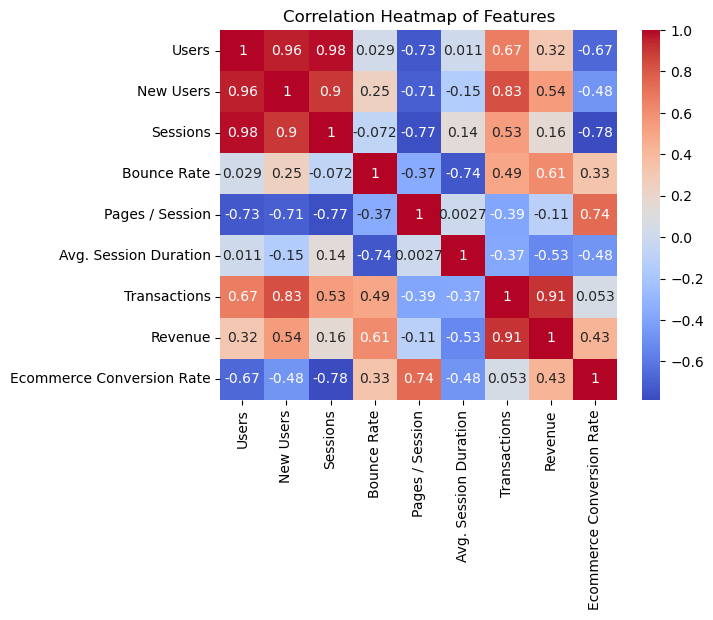

In [17]:
# Select the columns for correlation analysis
corr_df = df[['Users', 'New Users', 'Sessions', 'Bounce Rate', 'Pages / Session', 'Avg. Session Duration', 'Transactions', 'Revenue', 'Ecommerce Conversion Rate']]

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
# Show the plot
plt.show()

###  Relationship between Pages / Session and Avg. Session Duration

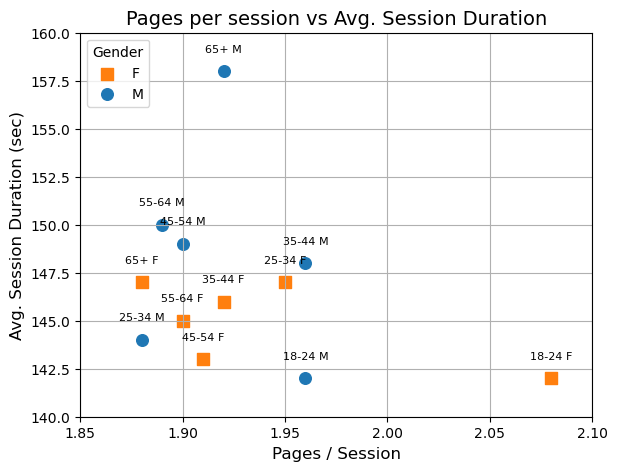

In [18]:
import matplotlib.pyplot as plt

# Data
ages = ['65+', '55-64', '45-54', '25-34', '45-54', '55-64', '25-34', '35-44', '65+', '35-44', '18-24', '18-24']
genders = ['F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M']
pages_session = [1.88, 1.9, 1.91, 1.95, 1.9, 1.89, 1.88, 1.92, 1.92, 1.96, 2.08, 1.96]
avg_duration = [147, 145, 143, 147, 149, 150, 144, 146, 158, 148, 142, 142]

# Create plot
fig, ax = plt.subplots()
colors = {'F': '#ff7f0e', 'M': '#1f77b4'}
markers = {'F': 's', 'M': 'o'}
legend_handles = []
legend_labels = []
for i in range(len(ages)):
    age = ages[i]
    gender = genders[i]
    page = pages_session[i]
    duration = avg_duration[i]
    label = f'{age} {gender}'
    if gender not in legend_labels:
        handle = ax.scatter([], [], c=colors[gender], marker=markers[gender], s=70, label=gender)
        legend_handles.append(handle)
        legend_labels.append(gender)
    ax.scatter(page, duration, c=colors[gender], marker=markers[gender], s=70, label=label)

# Add labels and title
ax.set_xlabel('Pages / Session', fontsize=12)
ax.set_ylabel('Avg. Session Duration (sec)', fontsize=12)
ax.set_title('Pages per session vs Avg. Session Duration', fontsize=14)

# Add legend
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', title='Gender')

# Add grid
ax.grid(True)

# Set limits
ax.set_xlim([1.85, 2.1])
ax.set_ylim([140, 160])

# Add annotations
for i in range(len(ages)):
    age = ages[i]
    gender = genders[i]
    page = pages_session[i]
    duration = avg_duration[i]
    ax.annotate(f'{age} {gender}', (page, duration+1), ha='center', fontsize=8)

# Adjust spacing
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# Show plot
plt.show()


### Relationships between the variables

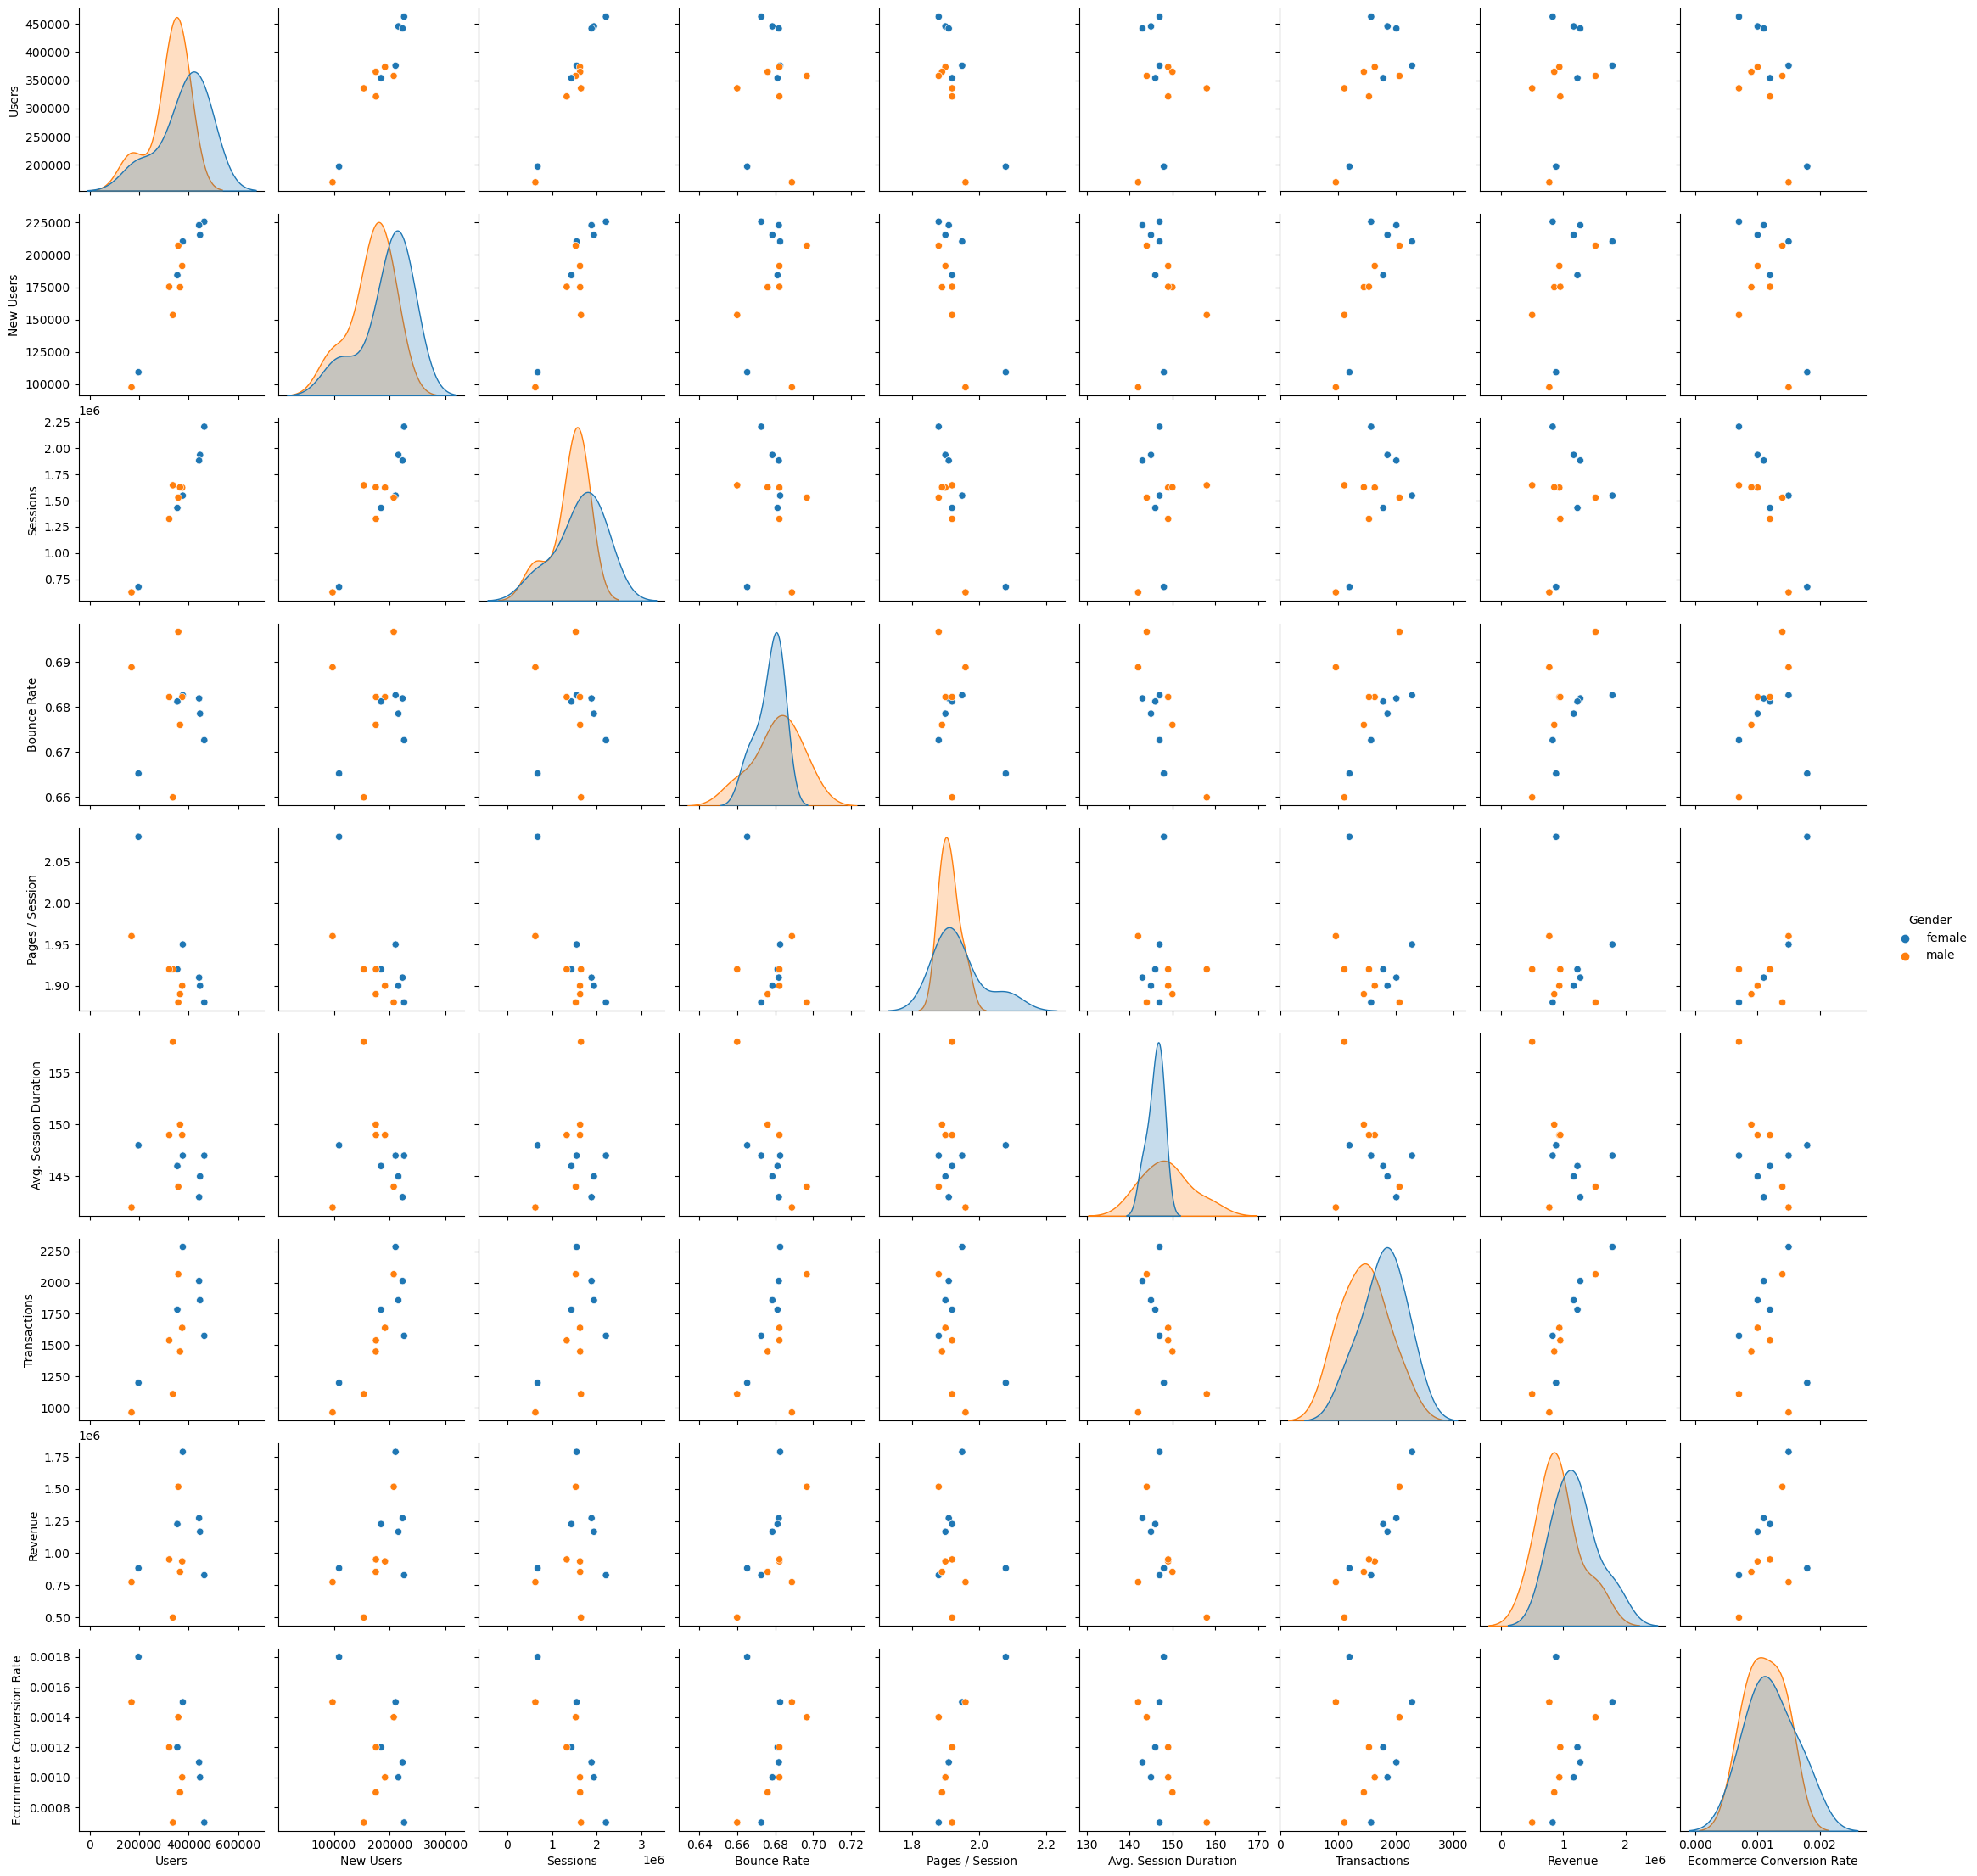

In [19]:
sns.pairplot(df, hue="Gender")

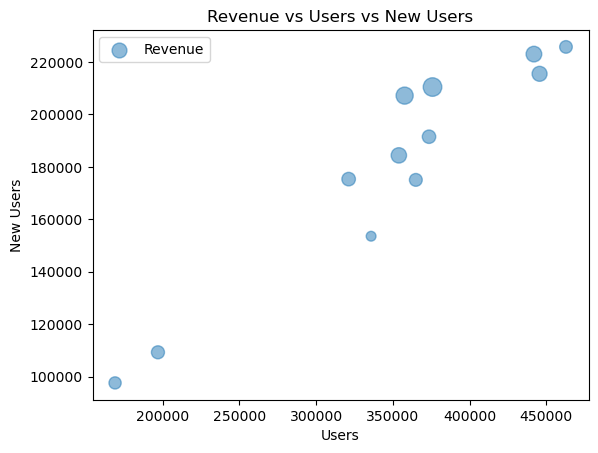

In [20]:
# Create a scatter plot
plt.scatter(df['Users'], df['New Users'], s=df['Revenue']/10000, alpha=0.5)

# Set the title and labels
plt.title('Revenue vs Users vs New Users')
plt.xlabel('Users')
plt.ylabel('New Users')

# Add a legend
plt.legend(['Revenue'])

# Show the plot
plt.show()

### Analysis between Revenue, Users, and New Users

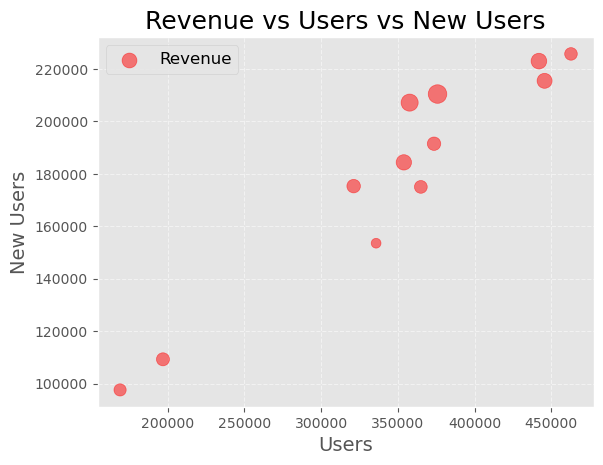

In [21]:
# Set the style to "ggplot"
plt.style.use('ggplot')

# Create a scatter plot
plt.scatter(df['Users'], df['New Users'], s=df['Revenue']/10000, alpha=0.5, color='red')

# Set the title and labels
plt.title('Revenue vs Users vs New Users', fontsize=18)
plt.xlabel('Users', fontsize=14)
plt.ylabel('New Users', fontsize=14)

# Add a legend
plt.legend(['Revenue'], fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

# Feature Engineering

In [102]:
# calculate new features
df['Sessions_per_User'] = df['Sessions'] / df['Users']
df['Average_Order_Value'] = df['Revenue'] / df['Transactions']
df['Revenue_per_User'] = df['Revenue'] / df['Users']

# print the updated dataset
print(df)

      Age  Gender   Users  New Users  Sessions  Bounce Rate  Pages / Session  \
0     65+  female  462771     225727   2202544       0.6726             1.88   
1   55-64  female  445571     215470   1934187       0.6785             1.90   
2   45-54  female  441885     222988   1880482       0.6819             1.91   
3   25-34  female  375829     210428   1547021       0.6826             1.95   
4   45-54    male  373548     191484   1623042       0.6822             1.90   
5   55-64    male  364955     175018   1626306       0.6760             1.89   
6   25-34    male  357661     207157   1527964       0.6967             1.88   
7   35-44  female  353895     184368   1430119       0.6812             1.92   
8     65+    male  335822     153539   1645170       0.6599             1.92   
9   35-44    male  321190     175314   1325544       0.6822             1.92   
10  18-24  female  196957     109269    677168       0.6652             2.08   
11  18-24    male  169028      97594    

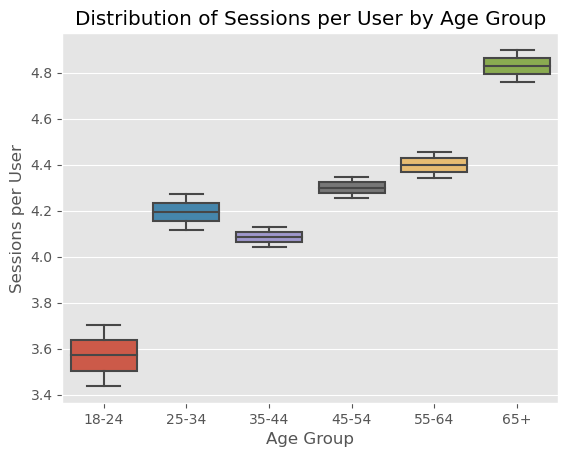

In [103]:
# Distribution of Sessions per User by Age Group
sns.boxplot(x='Age', y='Sessions_per_User', data=df)
plt.title('Distribution of Sessions per User by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Sessions per User')
plt.show()

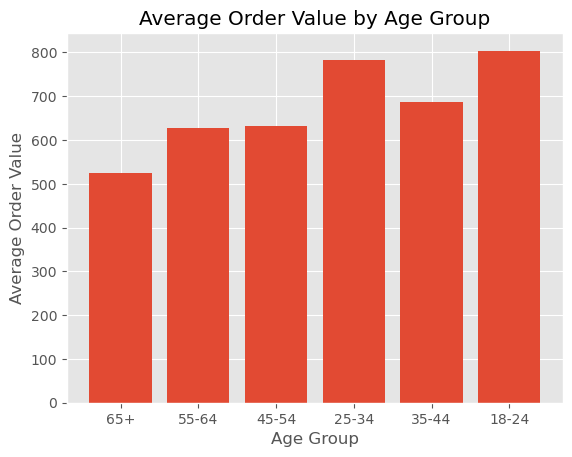

In [104]:
# Create a bar chart for Average_Order_Value
plt.bar(df['Age'], df['Average_Order_Value'])
plt.title('Average Order Value by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Order Value')
plt.show()

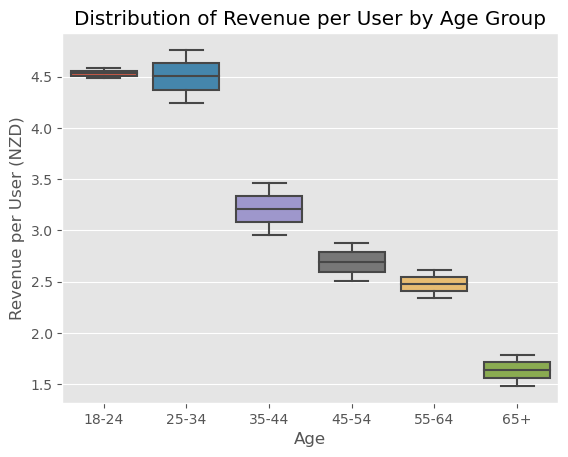

In [105]:
# Distribution of Revenue per User by Age Group
sns.boxplot(x='Age', y='Revenue_per_User', data=df)
plt.title('Distribution of Revenue per User by Age Group')
plt.xlabel('Age')
plt.ylabel('Revenue per User (NZD)')
plt.show()


# Machine Learning

In [106]:
print(df)

      Age  Gender   Users  New Users  Sessions  Bounce Rate  Pages / Session  \
0     65+  female  462771     225727   2202544       0.6726             1.88   
1   55-64  female  445571     215470   1934187       0.6785             1.90   
2   45-54  female  441885     222988   1880482       0.6819             1.91   
3   25-34  female  375829     210428   1547021       0.6826             1.95   
4   45-54    male  373548     191484   1623042       0.6822             1.90   
5   55-64    male  364955     175018   1626306       0.6760             1.89   
6   25-34    male  357661     207157   1527964       0.6967             1.88   
7   35-44  female  353895     184368   1430119       0.6812             1.92   
8     65+    male  335822     153539   1645170       0.6599             1.92   
9   35-44    male  321190     175314   1325544       0.6822             1.92   
10  18-24  female  196957     109269    677168       0.6652             2.08   
11  18-24    male  169028      97594    

## Random Forest Regressor

In [107]:
# Encoding categorical variables
label_encoder = LabelEncoder()
df['Users'] = label_encoder.fit_transform(df['Users'])
df['Sessions'] = label_encoder.fit_transform(df['Sessions'])

# Scaling numerical variables
scaler = StandardScaler()
num_vars = ['Users', 'New Users', 'Sessions', 'Bounce Rate', 'Pages / Session', 'Avg. Session Duration', 'Transactions', 'Revenue']
df[num_vars] = scaler.fit_transform(df[num_vars])

In [108]:
df = df.drop('Age', axis=1)

In [109]:
X = df.drop('Users', axis=1)
y = df['Users']

# Perform one-hot encoding on the categorical variable(s)
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
r2_score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('R2 score:', r2_score)
print('MSE:', mse)

R2 score: 0.6914763736263738
MSE: 0.5235552447552445


In [110]:
importance = rf.feature_importances_
feature_names = X.columns.tolist()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance_df.sort_values('importance', ascending=False, inplace=True)

print(feature_importance_df)


                      feature  importance
0                   New Users    0.308141
1                    Sessions    0.170080
3             Pages / Session    0.133038
9         Average_Order_Value    0.059725
4       Avg. Session Duration    0.058905
5                Transactions    0.046162
12                Gender_male    0.046120
8           Sessions_per_User    0.040165
7   Ecommerce Conversion Rate    0.035950
2                 Bounce Rate    0.035851
6                     Revenue    0.033193
11              Gender_female    0.016986
10           Revenue_per_User    0.015682


In [111]:
# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, max_depth=5)

# Fit the model to the training data
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [112]:
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve - Random Forest Regressor")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt


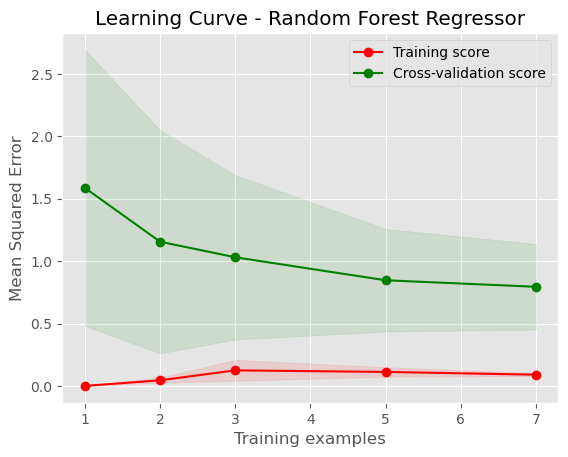

In [113]:
# Plot the learning curve
plot_learning_curve(model, X_train, y_train)
plt.show()

## Linear Regression

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [115]:
X = df.drop(['Users'], axis=1)
y = df['Users']
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [116]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [117]:
y_pred = model.predict(X_test)

In [118]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Mean Squared Error: ', mse)
print('R2 Score: ', r2)

Mean Squared Error:  0.6148989956178312
R2 Score:  0.15451388102548236


In [119]:
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve - Linear Regression")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt


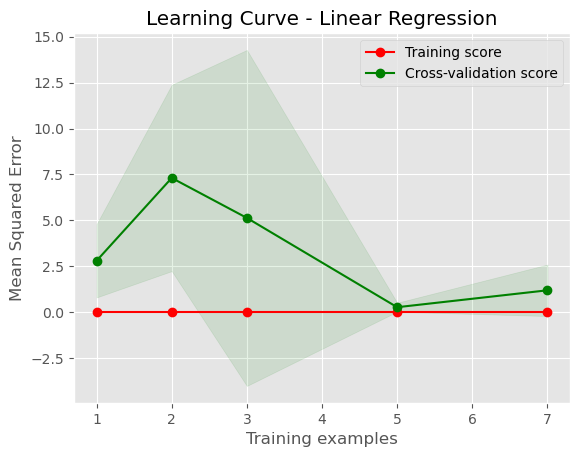

In [120]:
# Plot the learning curve
plot_learning_curve(model, X_train, y_train)
plt.show()

## Support Vector Regression

In [121]:
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

In [122]:
# Split the data into input features and target variable
X = df.drop(["Users"], axis=1)
y = df["Users"]

# One-hot encode the "Gender" column
X = pd.get_dummies(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Train an SVR model on the training data
model = SVR()
model.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)
print("R-squared:", r2)

Mean Squared Error:  1.7751678364589107
R-squared: -0.046081046484715005


In [124]:
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    
    plt.figure()
    plt.title("Learning Curve - Support Vector Regression")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt


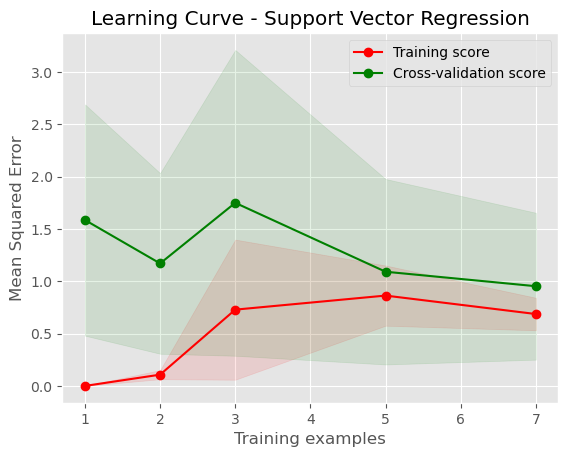

In [125]:
# Plot the learning curve
plot_learning_curve(model, X_train, y_train)
plt.show()